# Assignment 1: Get Familiar with Python and Data Processing

Your Name: Kavin Krishnakumar

Import necessary library tools into the environment; Please Google the name of each library to get feel for why they are all very useful.

In [82]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.signal import hilbert, chirp

sc = StandardScaler()


Step 1: Import the data from a accerelometer and gyroscope from "putty.log"

In [83]:
#open the file
fin = open(r"C:\Users\Kavin\Downloads\putty_V1.log", "r+")

#store data in 2d array
data = [line.strip().split(',') for line in fin]

line = fin.readline()
while(line):
#   data.append(line.split('\n'))
   data.append(line.split(','))
   line = fin.readline()

data = data[1:]
# double check the data integrity
#print(data)

Length of t (time): 14532
Length of aX (Acceleration X-axis): 14532
Length of aY (Acceleration Y-axis): 14532
Length of aZ (Acceleration Z-axis): 14532
Length of bX (Gyroscope X-axis): 14532
Length of bY (Gyroscope Y-axis): 14532
Length of bZ (Gyroscope Z-axis): 14532


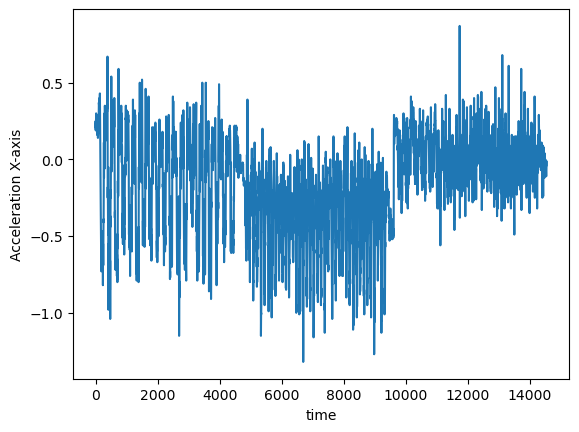

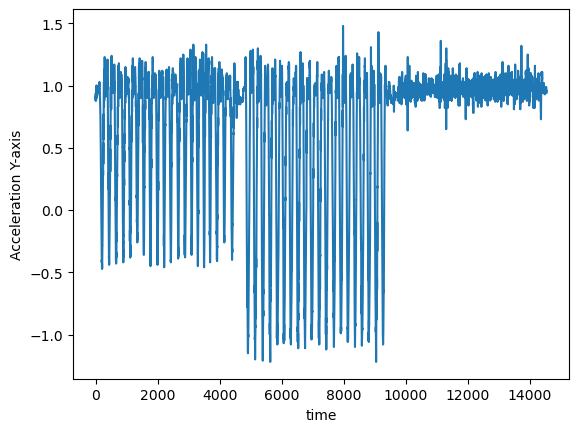

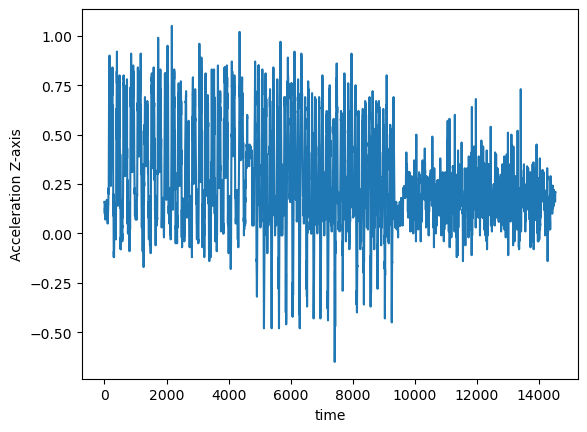

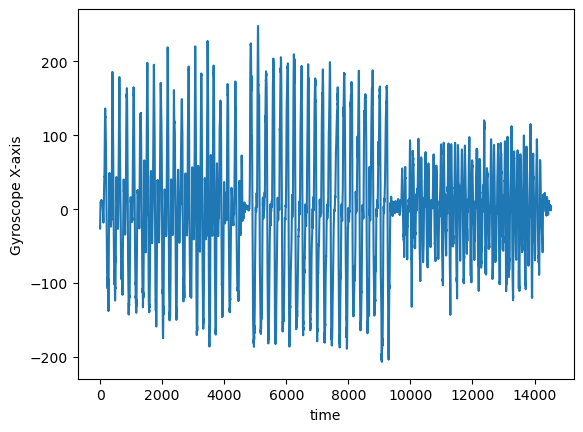

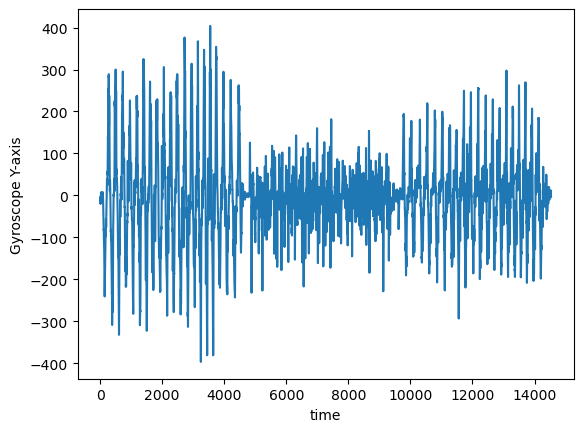

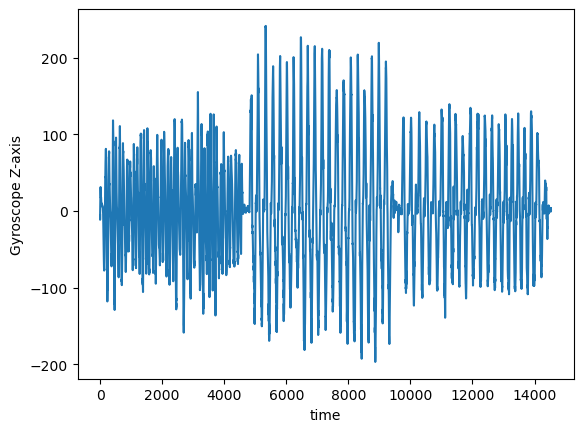

In [84]:
# Initialize variables
t = []
aX, aY, aZ = [], [], []
bX, bY, bZ = [], [], []
I = []

# Process data
time = 0
for log in data:
    if len(log) >= 11:  # Ensure valid data length
        try:
            # Append data to respective arrays
            aX.append(float(log[0]))
            aY.append(float(log[1]))
            aZ.append(float(log[2]))
            bX.append(float(log[6]))
            bY.append(float(log[7]))
            bZ.append(float(log[8]))
            I.append(float(log[10]))
            t.append(time)  # Synchronize t with other arrays
            time += 1
        except ValueError:
            continue  # Skip rows with invalid numeric values

# Check lengths
print(f"Length of t (time): {len(t)}")
print(f"Length of aX (Acceleration X-axis): {len(aX)}")
print(f"Length of aY (Acceleration Y-axis): {len(aY)}")
print(f"Length of aZ (Acceleration Z-axis): {len(aZ)}")
print(f"Length of bX (Gyroscope X-axis): {len(bX)}")
print(f"Length of bY (Gyroscope Y-axis): {len(bY)}")
print(f"Length of bZ (Gyroscope Z-axis): {len(bZ)}")

# Plot the data
plt.plot(t, aX)
plt.xlabel('time')
plt.ylabel("Acceleration X-axis")
plt.show()

plt.plot(t, aY)
plt.xlabel('time')
plt.ylabel("Acceleration Y-axis")
plt.show()

plt.plot(t, aZ)
plt.xlabel('time')
plt.ylabel("Acceleration Z-axis")
plt.show()

plt.plot(t, bX)
plt.xlabel('time')
plt.ylabel("Gyroscope X-axis")
plt.show()

plt.plot(t, bY)
plt.xlabel('time')
plt.ylabel("Gyroscope Y-axis")
plt.show()

plt.plot(t, bZ)
plt.xlabel('time')
plt.ylabel("Gyroscope Z-axis")
plt.show()


Step 2: Clipping data 

In [85]:
start = 100
amount = min(15500, len(data))  # Clip at the dataset's end
clipped_data = data[start:amount]
print("Length of the clipped data:", len(clipped_data))


Length of the clipped data: 14432


Step 3: Chunking: chopping each X,Y,Z, acceleration and each X,Y,Z, angular rotation acceleration data into many many equal size windows (hint: 20 data points per chunk)

In [86]:
def chunk_data(arr, chunk_size):
    return [arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)]

chunk_size = 20
chunks_aX = chunk_data(aX, chunk_size)
chunks_aY = chunk_data(aY, chunk_size)
chunks_aZ = chunk_data(aZ, chunk_size)
chunks_bX = chunk_data(bX, chunk_size)
chunks_bY = chunk_data(bY, chunk_size)
chunks_bZ = chunk_data(bZ, chunk_size)


Step 4: Feature Extraction: find (1) mean, (2) rms, (3)slope sign change, (4) number of positive peaks, (5) number of negative peaks, (6) number of zero crossing

In [87]:
#MEAN
def calc_mean(chunk):
    return np.mean(chunk)


In [88]:
#RMS
def calc_rms(chunk):
    return np.sqrt(np.mean(np.square(chunk)))


In [89]:
#Slope Sign Change
def slope_sign_change(chunk):
    sc = 0
    for i in range(len(chunk) - 2):
        slope1 = chunk[i + 1] - chunk[i]
        slope2 = chunk[i + 2] - chunk[i + 1]
        if slope1 * slope2 < 0:
            sc += 1
    return sc


In [90]:
#Positive peaks and negative peaks
from scipy.signal import find_peaks

def num_positive_peaks(chunk):
    peaks, _ = find_peaks(chunk)
    return len(peaks)

def num_negative_peaks(chunk):
    inverted_chunk = [-x for x in chunk]
    peaks, _ = find_peaks(inverted_chunk)
    return len(peaks)



In [91]:
#Zero Crossing
def zero_crossings(chunk):
    return len(np.where(np.diff(np.sign(chunk)))[0])


In [92]:
features = []
for chunk in chunks_aX:  # Repeat for all axes
    features.append({
        "mean": calc_mean(chunk),
        "rms": calc_rms(chunk),
        "slope_changes": slope_sign_change(chunk),
        "positive_peaks": num_positive_peaks(chunk),
        "negative_peaks": num_negative_peaks(chunk),
        "zero_crossings": zero_crossings(chunk)
    })


Step 5: Reconstruction of the data matrix

In [93]:
feature_matrix = []
for i in range(len(chunks_aX)):  # Assuming all chunks have the same length
    row = [
        calc_mean(chunks_aX[i]), calc_rms(chunks_aX[i]), slope_sign_change(chunks_aX[i]),
        num_positive_peaks(chunks_aX[i]), num_negative_peaks(chunks_aX[i]), zero_crossings(chunks_aX[i]),
        calc_mean(chunks_aY[i]), calc_rms(chunks_aY[i]), slope_sign_change(chunks_aY[i]),
        # Repeat for all axes...
    ]
    feature_matrix.append(row)

feature_matrix = np.array(feature_matrix)
print("Feature matrix shape:", feature_matrix.shape)


Feature matrix shape: (727, 9)


In [94]:
def slope_sign_change(arr):
    """
    Checks if there is a sign change in the slope of the array.
    Returns True if there is a sign change, False otherwise.
    """
    sc = 0
    for i in range(len(arr)-2):
        slope1 = arr[i+1] - arr[i]
        slope2 = arr[i+2] - arr[i+1]
        if slope1 * slope2 < 0:
            sc += 1
            return
    return sc

In [95]:
a = slope_sign_change([1, 2, -1, -2, 1])

In [96]:
print(a)

None


In [97]:
arr=np.array([1, 2, -1, -2, 1])

In [98]:
sc = 0
for i in range(len(arr)-2):
    slope1 = arr[i+1] - arr[i]
    slope2 = arr[i+2] - arr[i+1]
    if slope1 * slope2 < 0:
        sc += 1
print (sc)

2
